# Training a dense neural network to imitate a simulator

In this notebook, we explain how to use our package to train a simple neural network to imitate the output of an AC power flow simulator.

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import tqdm
import jax
import jax.numpy as jnp

%load_ext autoreload
%autoreload 2

import sys; sys.path.insert(0, '../../..')
import ml4ps as mp

## Downloading a dataset

First of all, we need to download a dataset. We propose to download a small dataset of power grids derived from the case60nordic file (also known as nordic32), randomly generated using [powerdatagen](https://github.com/bdonon/powerdatagen).

The dataset is available on zenodo [here](https://zenodo.org/record/7077699). The following code downloads the dataset if it is not already here. Please be patient, as it may take several minutes (not more than 10 minutes though).

If you have already downloaded the dataset, then this does nothing.

In [2]:
%%bash
if [ ! -d data/case60/ ]
then
    zenodo_get '10.5281/zenodo.7077699' -o data/
    unzip -qq data/case60.zip -d data/
    rm data/case60.zip data/md5sums.txt
fi

## Backend instantation

We need to import a backend, which will serve to read power grid data. In some more complex problem, it will be used to perform power grid simulations.

In this case, we are considering a dataset of .json files that can be read by pandapower. We thus choose the backend that uses pandapower.

In [3]:
backend = mp.PandaPowerBackend()

In [4]:
train_dir = 'data/case60/train'

## Building a normalizer

In [5]:
normalizer = mp.Normalizer(data_dir=train_dir, backend=backend)

Extracting features.: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.45it/s]


## Building a train set and a data loader

The normalizer is fed to the data loader, so that ...

In [6]:
train_set = mp.PowerGridDataset(data_dir=train_dir, backend=backend, normalizer=normalizer)
train_loader = DataLoader(train_set,
                          batch_size=1,
                          shuffle=True,
                          num_workers=2,
                          collate_fn=mp.collate_power_grid,
                          prefetch_factor=8)

## Building a Fully Connected neural network

First of all, we need to tell the neural network which features it should take as input, and wich features we want it to output. In this case, we want the neural network to output predictions for the voltage magnitude at each bus.

In [7]:
input_feature_names = {'load': ['p_mw', 'q_mvar'], 'gen': ['p_mw', 'vm_pu'], 'ext_grid': ['vm_pu']}
output_feature_names = {'bus': ['res_vm_pu']}

In [8]:
# data_structure = {
#     'load': {'input_feature_names': ['p_mw', 'q_mvar']},
#     'gen': {'input_feature_names': ['p_mw', 'vm_pu']},
#     'ext_grid': {'input_feature_names': ['vm_pu']},
#     'bus': {'output_feature_names': ['res_vm_pu']}
# }

Since we are working with a fully connected neural network, we need to pass a sample to the constructor, so that  it knows how many object of each class will be present in the data. This is due to the fact that fully connected neural networks can only take vector data as input. By telling the neural network the amount of objects, it is able to initialize its weights using the right dimensions.

In [9]:
x, nets = next(iter(train_loader))

fully_connected = mp.FullyConnected(
    x=x,
    input_feature_names=input_feature_names,
    output_feature_names=output_feature_names,
    hidden_dimensions=[1024,1024])

In addition, we need to specify post-processing functions, so that our model starts its training in a reasonable range. Here, we know that voltage magnitudes should be around 1 p.u., so we post-process the neural network output by adding an offset of 1.

In [10]:
functions = {'bus': {'res_vm_pu': [mp.AffineTransform(offset=1.)]}}
postprocessor = mp.PostProcessor(functions=functions)

## Training loop

Here, we propose to train our neural network using the Adam optimizer. The loss function is the squared distance between the neural network prediction and the output of the simulator.

In [11]:
from jax.example_libraries import optimizers

learning_rate = 3e-4
opt_init, opt_update, get_params = optimizers.adam(learning_rate)
opt_state = opt_init(fully_connected.params)

In [12]:
def loss_function(params, x, y):
    y_hat = fully_connected.apply(params, x)
    y_post = postprocessor(y_hat)
    loss = jnp.mean((y_post['bus']['res_vm_pu'] - y['bus']['res_vm_pu'])**2)
    return loss

@jax.jit
def update(params, x, y, opt_state, step):
    loss, grads = jax.value_and_grad(loss_function)(params, x, y)
    opt_state = opt_update(step, grads, opt_state)
    return get_params(opt_state), opt_state, loss

In [13]:
step = 0
for epoch in range(2):
    for x, nets in (pbar := tqdm.tqdm(train_loader)):
        step += 1
        
        backend.run_batch(nets) # AC power flow simulation 
        y = backend.get_data_batch(nets, feature_names={'bus':['res_vm_pu']}) # Ground truth extraction
        fully_connected.params, opt_state, loss = update(fully_connected.params, x, y, opt_state, step)
        
        pbar.set_description("Epoch {}, Loss = {:.2e}".format(epoch, loss))

Epoch 0, Loss = 2.32e-04:  18%|████████████████████████████████████████████▎                                                                                                                                                                                                       | 1816/10000 [00:58<04:23, 31.02it/s]


KeyboardInterrupt: 

## Testing the model

We now wish to take a look at how well our model performs on the test data. In this notebook we propose to plot the ground truth versus the prediction for a sample of data.

In [14]:
test_dir = 'data/case60/test'
test_set = mp.PowerGridDataset(data_dir=test_dir, backend=backend, normalizer=normalizer)
test_loader = DataLoader(test_set,
                          batch_size=8,
                          shuffle=True,
                          num_workers=2,
                          collate_fn=mp.collate_power_grid,
                          prefetch_factor=8)

In [15]:
x, nets = next(iter(test_loader))

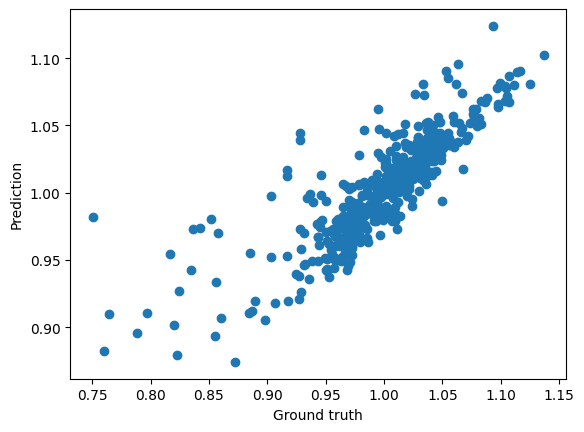

In [16]:
# Perform prediction
y_hat = fully_connected.apply(fully_connected.params, x)
y_post = postprocessor(y_hat)
y_post = np.reshape(y_post['bus']['res_vm_pu'], [-1])

# Get ground truth
y_truth = backend.get_data_batch(nets, feature_names={'bus':['res_vm_pu']})
y_truth = np.reshape(y_truth['bus']['res_vm_pu'], [-1])

# Compare results
import matplotlib.pyplot as plt
plt.scatter(y_truth, y_post)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')
plt.show()